In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (에러 시 생략 가능)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from modules.preprocess_cols import (
    preprocess_telco_columns, add_derived_features,
    scale_numeric_features, load_model_with_assets
)

# ✅ 1. 데이터 로딩 및 전처리
df_raw = pd.read_csv('../data/telco.csv')
df_proc, _ = preprocess_telco_columns(df_raw)
df_proc = add_derived_features(df_proc)

# ✅ 2. 모델에서 사용한 스케일러 로드
bundle = load_model_with_assets()
scaler = bundle['scaler']

# ✅ 3. 스케일링 (전체 수치형 기준)
numeric_cols = df_proc.select_dtypes(include=['float64', 'int64']).columns.difference(['Churn']).tolist()
df_proc_scaled, _ = scale_numeric_features(df_proc, numeric_cols, scaler=scaler)

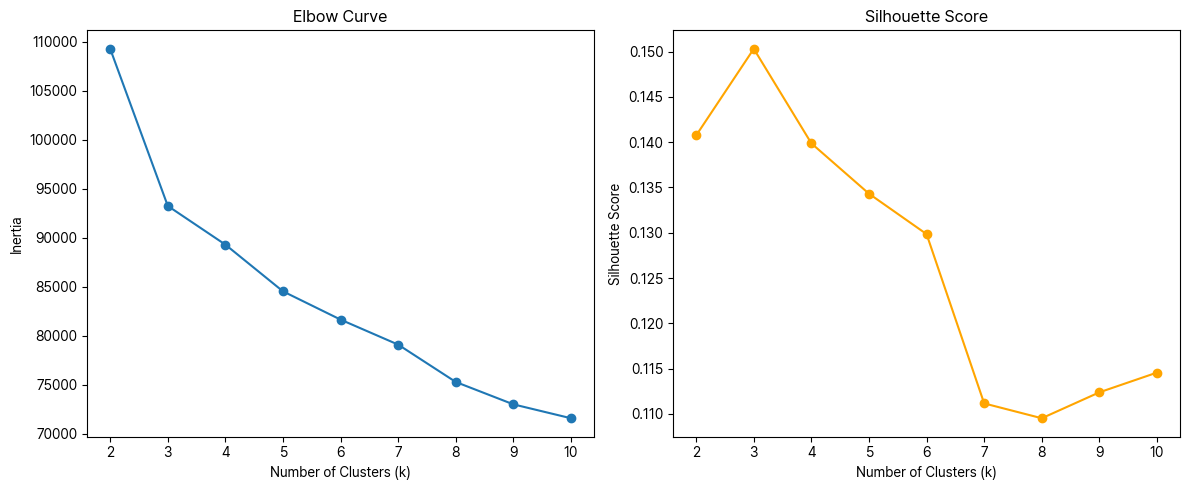

In [9]:
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    preds = km.fit_predict(X_cluster)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_cluster, preds))

# 📈 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

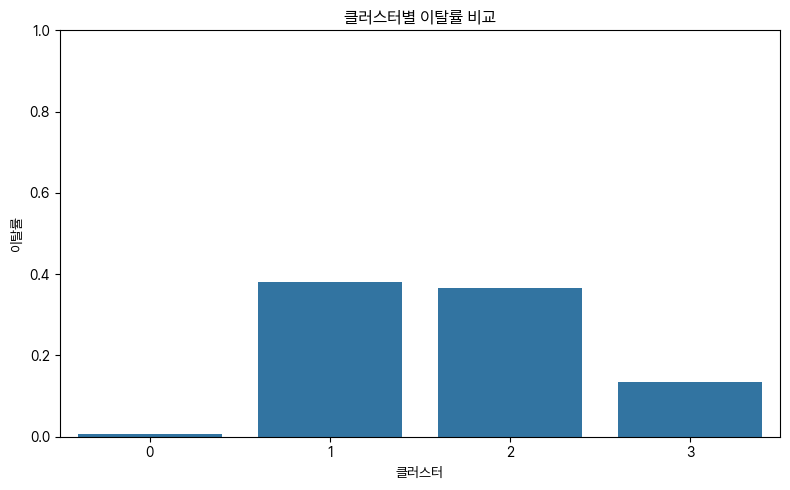

클러스터별 이탈률 요약


,고객 수,이탈 수,이탈률
Cluster,,,
0,948,6,0.006329
1,2110,801,0.379621
2,2272,832,0.366197
3,1713,230,0.134267



클러스터별 주요 변수 평균값


,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,CLTV,Latitude,Longitude,Monthly Charge,Number of Dependents,Number of Referrals,Population,Satisfaction Score,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Zip Code
Cluster,,,,,,,,,,,,,,,,,,
0,-0.22,-0.52,0.06,0.26,0.25,-0.25,-1.00,1.09,0.97,-0.14,0.60,0.56,-0.33,-0.19,0.37,0.04,-0.15,0.23
1,0.04,-0.05,-0.12,-0.32,0.91,-0.89,-0.14,-0.29,-0.40,-0.40,-0.20,-0.61,-0.53,-0.04,-0.51,-0.02,-0.57,0.88
2,0.02,0.00,-0.15,-0.27,-0.93,0.91,-0.16,-0.19,-0.31,0.44,-0.14,-0.54,-0.50,-0.04,-0.49,-0.01,-0.54,-0.91
3,0.04,0.35,0.32,0.61,-0.02,0.03,0.95,0.00,0.36,-0.02,0.10,1.16,1.50,0.21,1.07,0.01,1.50,-0.01


In [10]:
# ✅ 4. KMeans 클러스터링 적용
k = 4  # 군집 수 설정
X_cluster = df_proc_scaled[numeric_cols]
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
df_proc_scaled['Cluster'] = kmeans.fit_predict(X_cluster)

# ✅ 5. 군집별 이탈률 계산
cluster_summary = df_proc_scaled.groupby('Cluster')['Churn'].agg(['count', 'sum', 'mean']).rename(
    columns={'count': '고객 수', 'sum': '이탈 수', 'mean': '이탈률'}
)

# ✅ 6. 군집별 주요 특성 평균 출력
feature_means = df_proc_scaled.groupby('Cluster')[numeric_cols].mean()

# ✅ 7. 시각화 (옵션)
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_summary.index, y=cluster_summary['이탈률'])
plt.title("클러스터별 이탈률 비교")
plt.xlabel("클러스터")
plt.ylabel("이탈률")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# ✅ 8. 출력
print("클러스터별 이탈률 요약")
display(cluster_summary)

print("\n클러스터별 주요 변수 평균값")
display(feature_means.round(2))

모든 변수는 표준화(Z-score 스케일) 기준 → 0보다 크면 평균 이상

주요 기준 변수:
Satisfaction Score, Monthly Charge, Tenure, CLTV, Number of Referrals, Dependents

### 🟢 Cluster 0 – 충성 고객 페르소나 (이탈률 0.6%)

- **주요 특성:**
  - Satisfaction Score: +0.60
  - Monthly Charge: -1.00 (저요금제)
  - Tenure: +0.56 (장기 체류)
  - Number of Referrals: +1.09
  - Dependents: +0.97

- **페르소나 요약:**  
  “가족 단위 저요금 장기 사용자, 만족도 높고 추천도 활발한 충성 고객군”

- **리텐션 전략:**
  - 장기고객 대상 리워드 강화
  - 추천 리워드 유지
  - 해지 유도 흐름 최소화 (해지 UX 축소)

### 🔴 Cluster 1 – 불만족 이탈 고위험군 (이탈률 37.9%)

- **주요 특성:**
  - Satisfaction Score: -0.20
  - Tenure: -0.61 (단기 체류)
  - CLTV: -0.32
  - Referrals: -0.29
  - Dependents: -0.40

- **페르소나 요약:**  
  “불만족 + 단기 체류 + 추천 경험 없음 + 가족 없음의 이탈 고위험 고객군”

- **리텐션 전략:**
  - 만족도 설문 기반 UX 개선
  - 첫 해 혜택/보상 캠페인
  - 해지 전 보안/요금 최적화 제안 알림

### 🔴 Cluster 2 – 고요금 민감 고객군 (이탈률 36.6%)

- **주요 특성:**
  - Monthly Charge: +0.91 (고요금제)
  - Satisfaction Score: -0.14
  - Tenure: -0.54 (단기 체류)
  - Total Charges: -0.50
  - CLTV: -0.27

- **페르소나 요약:**  
  “고요금인데 만족도 낮고 체류기간 짧은 요금 민감 고객군”

- **리텐션 전략:**
  - 요금 리포트 기반 리마인더
  - 사용패턴 기반 맞춤 요금제 추천
  - 일시적 요금 혜택(쿠폰 등) 제공

### 🟡 Cluster 3 – 고지불 장기 고객군 (이탈률 13.4%)

- **주요 특성:**
  - Monthly Charge: +0.95
  - Tenure: +1.16
  - CLTV: +0.61
  - Total Revenue: +1.50

- **페르소나 요약:**  
  “만족도 무난하며, 고요금 장기 사용자인 잠재 우량 고객군”

- **리텐션 전략:**
  - 멤버십 등급/우대 혜택 제안
  - 장기고객 리워드 설계
  - 사용량 급감 시 실시간 리마인드

# 리텐션 기능 설계

### 🟢 Cluster 0 – 충성 고객군

📌 기능명: VIP 감사 리워드 팝업

- ✅ 대상 조건: Cluster 0에 속한 고객 (이탈률 < 1%)
- ⏰ 적용 시점: 6개월 이상 체류 + 매출 상위 30% 고객
- ✉️ 전달 방식: 마이페이지 내 등급 노출 + 주간 혜택 알림

🎯 목적:
- 장기 고객 유지율 향상
- 추천 유도 및 감정적 만족 강화

📎 예시 문구:
“OO님은 VIP 고객입니다. 6개월 이상 이용해주셔서 감사합니다. 이번 달 전용 혜택이 도착했어요!”

### 🔴 Cluster 1 – 불만족·단기 이탈 고위험군
📌 기능명: 이탈 방지 리마인드 + 개선 제안 설문

- ✅ 대상 조건: Cluster 1 소속 고객 중 Tenure < 3개월
- ⏰ 적용 시점: 해지 시도 전 또는 만족도 3점 이하 기록 시
- ✉️ 전달 방식: 앱 알림 + 해지 UX 중간 인터셉트

🎯 목적:
- 이탈 전 행동에서 바로 리텐션 개입
- 고객 불만 요인 실시간 수집 및 개선 연결

📎 예시 문구:
“서비스가 기대에 미치지 못하셨나요? 해지 전에 혜택이나 개선안 확인해보세요.”


### 🔴 Cluster 2 – 고요금 민감 이탈군

📌 기능명: 요금 최적화 리포트 + 즉시 전환 제안

- ✅ 대상 조건: Cluster 2 소속 고객 중 월 요금 상위 20%
- ⏰ 적용 시점: 최근 1개월 요금 급등 또는 사용량 대비 비효율 분석 시
- ✉️ 전달 방식: 이메일 리포트 + 앱 내 리마인드 배너

🎯 목적:
- 요금 민감 고객의 해지 이유 차단
- 개인화 요금제 전환 유도

📎 예시 문구:
“지금 요금제가 OOO님의 사용 패턴과 맞지 않을 수 있어요. 최적화된 요금제 제안이 도착했어요!”

### 🟡 Cluster 3 – 고지불 장기 고객

📌 기능명: 멤버십 등급 노출 + 혜택 개별 브리핑

- ✅ 대상 조건: Cluster 3 소속 고객 중 CLTV ≥ 평균 이상
- ⏰ 적용 시점: 장기고객(>1년) 도달 시 자동
- ✉️ 전달 방식: 월간 보고서 형태 + 마케팅 전용 알림

🎯 목적:
- 고가치 장기 고객에 대한 감정적 락인 강화
- 이탈 징후 조기 감지 및 개입

📎 예시 문구:
“지난 12개월간 누적 이용액 120만 원 이상! OOO님은 [프리미엄 멤버]입니다. 이번 달 혜택을 확인해보세요.”

# 시퀀스 설계

1. 목표 
"각 클러스터에 맞는 리텐션 기능이 언제, 어떤 조건에서, 어떤 UX 흐름으로 사용자에게 도달하는지"
→ 사용자 흐름도(시퀀스 다이어그램) 형태로 명확히 설명

2. 진행 순서

| 단계             | 내용                       | 예시                      |
| -------------- | ------------------------ | ----------------------- |
| ① 기능 선택        | ex) Cluster 1 – 이탈 방지 설문 |                         |
| ② 주요 조건 정의     | 어떤 조건에서 기능이 작동하는가        | ex) 만족도 ≤ 3점 + 해지 버튼 클릭 |
| ③ 주체 정의        | 사용자 / 시스템 / DB / UI      |                         |
| ④ 상호작용 순서 나열   | 시간 순서대로 step 정리          | ex) 클릭 → 조건검사 → 팝업 노출   |
| ⑤ 시퀀스 다이어그램 작성 | 텍스트 or 도식                |                         |


3. 사용 요소 정의 
- 사용자 (User): 앱을 조작하는 고객
- 프론트(UI): 버튼, 화면, 팝업
- 백엔드 시스템: 조건 판단, 로그 확인, DB 호출
- 알림 서비스: 이메일, 앱 푸시 등 외부 전달 수단

### 🟢 Cluster 0 – VIP 감사 리워드 기능

📌 조건
- Cluster 0 고객
- Tenure ≥ 6개월
- 추천 경험 있음 (Referrals > 0)
- CLTV ≥ 평균 이상

🧾 사용자 시나리오 요약 (서술형)

고객 B는 9개월째 서비스 이용 중이며, 추천 이력을 2건 보유한 충성 고객이다.
마이페이지 접속 시, 백엔드에서 CLTV와 추천 이력을 조회해 VIP 조건을 충족한 것으로 판단.
VIP 혜택 배너가 노출되고, 고객은 해당 배너를 클릭하여 특별 포인트를 수령한다.
혜택은 앱 알림으로도 반복 안내되어 사용률을 높인다.

### 🔴 Cluster 1 – 이탈 방지 리마인드 + 설문 기능

📌 조건
- Cluster 1 고객
- Tenure ≤ 3개월
- 만족도 3점 이하
- 또는 해지 버튼 클릭 시

🧾 사용자 시나리오 요약 

고객 A는 가입 1개월차이며, 최근 서비스 만족도를 2점으로 기록함.
마이페이지 접속 시 백엔드에서 조건을 감지하여 “불만족 설문” 팝업을 띄움.
고객이 설문을 제출하면 시스템은 해당 응답을 저장하고, 보상 혜택 쿠폰 발송 로직을 실행함.
이후 고객에게는 앱 알림으로 “설문 감사 혜택” 메시지가 도달함.

### 🔴 Cluster 2 – 요금 최적화 리포트 + 전환 제안 기능

📌 조건
- Cluster 2 고객
- 최근 3개월 평균 Monthly Charge ≥ 상위 20%
- CLTV < 평균
- 요금 대비 사용량 불균형 감지

🧾 사용자 시나리오 요약

고객 C는 최근 3개월간 매달 90,000원을 사용했지만, 데이터나 통화 이용량은 낮은 편이었다.
시스템은 요금 대비 사용 효율이 낮다는 판단하에, 맞춤형 리포트 배너를 앱에 노출했다.
고객은 이를 통해 더 저렴한 요금제를 확인하고 전환을 완료했다.
알림을 통해도 동일한 메시지를 받아 리텐션이 유도되었다.

### 🟡 Cluster 3 – 멤버십 등급 브리핑 기능

📌 조건
- Cluster 3 고객
- Tenure ≥ 12개월
- CLTV ≥ 상위 30%
- Total Revenue ≥ 평균 이상

🧾 사용자 시나리오 요약

고객 D는 1년 이상 고요금제를 유지하며 매출 상위권을 기록한 사용자다.
월말 접속 시, 시스템은 조건 충족을 감지하여 [골드 등급 전용 혜택] 알림을 노출한다.
고객은 등급 별 혜택 페이지를 확인하고 포인트와 전용 할인권을 수령하며, 만족도와 잔존율이 강화된다.

# QA 테스트 시나리오

구성요소

| 항목               | 설명                   |
| ---------------- | -------------------- |
| **Test Case ID** | 기능/군집 기준 고유 ID       |
| **대상 클러스터**      | Cluster 0 \~ 3       |
| **테스트 조건**       | 어떤 상태에서 기능이 작동해야 하는가 |
| **입력값 (예시)**     | 테스트를 위한 데이터 시나리오     |
| **예상 동작**        | UI/알림/처리결과 등 기대 반응   |
| **비고**           | 확인사항 또는 특이점          |


## ✅ QA 테스트 시나리오 (클러스터별)

---

### 🔴 Cluster 1 – 이탈 방지 리마인드 + 설문 기능

| Test Case ID | 테스트 조건 | 입력값 예시 | 예상 동작 | 비고 |
|--------------|-------------|--------------|-------------|------|
| `QA-C1-001` | 가입 1개월 이하 + 만족도 2점 | `Tenure=1`, `Satisfaction=2` | 설문 팝업 노출 | 해지 UX 아닌 경우에도 팝업 발생 |
| `QA-C1-002` | 해지 버튼 클릭 시 | `click_cancel=1` | "불만족 설문" 팝업 노출 | 응답 저장 후 해지 지연 |
| `QA-C1-003` | 설문 응답 후 혜택 전송 | 응답: `"설명이 부족하다"` | 응답 저장 + 쿠폰 알림 발송 | 알림 도달 확인 필요 |

---

### 🟢 Cluster 0 – VIP 감사 리워드 기능

| Test Case ID | 테스트 조건 | 입력값 예시 | 예상 동작 | 비고 |
|--------------|-------------|--------------|-------------|------|
| `QA-C0-001` | 가입 9개월 + 추천 1건 | `Tenure=9`, `Referrals=1` | VIP 혜택 배너 노출 | CLTV ≥ 평균 필요 |
| `QA-C0-002` | VIP 배너 클릭 | `click_vip=1` | 혜택 상세 페이지 이동 | 등급명 노출 확인 |
| `QA-C0-003` | 혜택 수령 후 재접속 | `login+1` | 혜택 수령 상태 유지 | 중복 수령 방지 확인 |

---

### 🔴 Cluster 2 – 요금 최적화 리포트 + 전환 제안

| Test Case ID | 테스트 조건 | 입력값 예시 | 예상 동작 | 비고 |
|--------------|-------------|--------------|-------------|------|
| `QA-C2-001` | 월 요금 9만원 + 데이터 사용량 낮음 | `MonthlyCharge=90k`, `GB=1` | 요금 최적화 배너 노출 | 효율 분석 조건 충족 필요 |
| `QA-C2-002` | 리포트 보기 클릭 | `click_optimize=1` | 요금제 비교 리포트 노출 | 추천 요금제 옵션 확인 |
| `QA-C2-003` | 요금제 전환 선택 | `change_plan=1` | 요금제 변경 처리 완료 + 알림 발송 | 로그 저장 여부 확인 |

---

### 🟡 Cluster 3 – 멤버십 등급 브리핑 기능

| Test Case ID | 테스트 조건 | 입력값 예시 | 예상 동작 | 비고 |
|--------------|-------------|--------------|-------------|------|
| `QA-C3-001` | 가입 12개월 + 누적 결제 120만 원 | `Tenure=12`, `Revenue=120만` | 골드 등급 배너 노출 | 등급별 분기 기준 정확성 확인 |
| `QA-C3-002` | 혜택 상세 확인 클릭 | `click_benefit=1` | 혜택 상세 페이지 이동 | 혜택 수령 조건 명시 필요 |
| `QA-C3-003` | 혜택 수령 후 알림 | `coupon_used=1` | “혜택 사용 완료” 알림 발송 | 중복 사용 방지 확인 필요 |